In [2]:
import os
import tqdm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm
from sklearn.decomposition import PCA

In [3]:
!ls $BENCHMARK_RESULTS_DIR/jan

CIS-BP_PBM.zip
correlation_matrices.zip
correlations_cisbp_human.tsv
correlations_cisbp_inferred.tsv
correlations_homo_sapiens.tsv
correlations_homo_sapiens_manually_selected.tsv
correlations_vertebrates.tsv
correlations_vertebrates_manually_selected.tsv


In [4]:
BENCHMARK_RESULTS_DIR = "/home/penzard/benchmarking/"

DATASETS = {
    'hocomoco_jolma_yang' : os.path.join(BENCHMARK_RESULTS_DIR, "jolma_yang_hocomoco_roc10.txt"),
    'hocomoco_jolma_yang_shuffled': os.path.join(BENCHMARK_RESULTS_DIR, "jolma_yang_shuf_hocomoco_roc10.txt"),
    'motifs_info': os.path.join(BENCHMARK_RESULTS_DIR, "motifs_prefinal.tsv"),
    "hocomoco_jolma": os.path.join(BENCHMARK_RESULTS_DIR, 'hocomoco_jolma.txt'),
    'jolma_yang_jaspar': os.path.join(BENCHMARK_RESULTS_DIR, 'jolma_yang_jaspar_roc10.txt'),
    'jolma_yang_jaspar_shuffled': os.path.join(BENCHMARK_RESULTS_DIR, 'jolma_yang_shuf_jaspar_roc10.txt'),
    'correlations_homo': os.path.join(BENCHMARK_RESULTS_DIR, 'jan/correlations_homo_sapiens.tsv'),
    'correlations_homo_selected': os.path.join(BENCHMARK_RESULTS_DIR, 'jan/correlations_homo_sapiens_manually_selected.tsv'),
    'correlations_vertebrates': os.path.join(BENCHMARK_RESULTS_DIR, 'jan/correlations_vertebrates.tsv'),
    'correlations_vertebrates_selected' : os.path.join(BENCHMARK_RESULTS_DIR, 'jan/correlations_vertebrates_manually_selected.tsv'),
    'hocomoco_jolma_yang_shuffled_new': "/home/penzard/phylip_new/jolma_yang_shuf_hocomoco_new_roc10.txt",
    'cisbp_jan_new_exp': os.path.join(BENCHMARK_RESULTS_DIR, "JAN_NEW/EXP_correlations_homo_sapiens_manually_selected.tsv"),
    'cisbp_jan_new_log': os.path.join(BENCHMARK_RESULTS_DIR, "JAN_NEW/LOG_correlations_homo_sapiens_manually_selected.tsv"),
    
}

In [9]:
def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.zeros((n_replics, n_components))
    for i in tqdm.tqdm_notebook(range(n_replics)):
        if i % 100 == 0:
            print(f"{i} iter")
        random_data = dataset.copy().apply(np.random.permutation, axis=0)
        random_pca = PCA(n_components=n_components)
        random_pca.fit(random_data)
        variance_explained_by_chance[i, :] = random_pca.explained_variance_ratio_
    return variance_explained_by_chance

def get_pc_variance(dataset, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    return pca.explained_variance_ratio_

def plot_mean_and_CI(ax, values, label, ci_level=0.95, alpha_transparency=0.5, color_mean=None, color_shading=None):
    mean = values.mean(axis=0)
    
    std = values.std(axis=0)
    n = values.shape[1]
    se = std / np.sqrt(n) 
    
    q_alpha = (1-ci_level) / 2
    ci_num = np.abs(norm.ppf(q_alpha, loc=0, scale=1))
    
    lb = mean -  ci_num * se
    ub = mean + ci_num * se
    
    # plot the shaded range of the confidence intervals
    ax.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=alpha_transparency)
    # plot the mean on top
    ax.plot(mean, c=color_mean, lw=3, label=label)
    
def plot_explained_variance(ax, variance):
    ax.plot(variance, label='real', lw=3)
    ax.scatter(np.arange(0, variance.shape[0]), variance)
    
def plot_variance_by_change(ax, variance_by_chance):
    plot_mean_and_CI(ax, variance_by_chance, label='chance', color_mean='red', color_shading='red')

def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1/(permut_values.shape[0] * 10))
    
    p_values = np.zeros_like(real_values)
    for i in range(0, p_values.shape[0], 1):
        p_values[i] = (permut_values[:, i] >= real_values[i]).mean() + eps
    return p_values

def plot_explained_vs_chance(ax, explained_variance, variance_by_chance, dataset_name):
    plot_explained_variance(ax, explained_variance)
    plot_variance_by_change(ax, variance_by_chance)

    ax.set_title(f'PCA {dataset_name}', size=35)
    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("Explained variance ration", size=25)
    ax.set_xticks(np.arange(0, explained_variance.shape[0], 5))
    ax.set_xticklabels(np.arange(1, explained_variance.shape[0]+1, 5), size=20)

    ax.tick_params(labelsize=20, size=10)
    ax.set_ylim(0, explained_variance[0] + 0.1 )
    ax.legend(fontsize=20)

def plot_pval_plot(ax, p_values, dataset_name, alpha_level = 0.05, logscale=True):
    if logscale:
        p_values = -np.log10(p_values)
        alpha_level = -np.log10(alpha_level)

    
    ax.set_title(f"PC significance, {dataset_name}", size=35)
    ax.plot(p_values, lw=3)
    ax.scatter(np.arange(0, p_values.shape[0]), p_values, lw=3)

    ax.set_xlabel("Component number", size=25)
    ax.set_ylabel("-log(pvalue + eps)", size=25)
    ax.set_xticks(np.arange(0, p_values.shape[0], 5))
    ax.set_xticklabels(labels = np.arange(1, p_values.shape[0]+1, 5), size=20)
    ax.tick_params(labelsize=20, size=10)
    

    ax.hlines(y=alpha_level, xmin=0, xmax=100, color="red", linestyles="dashed", lw=3)
    
    
def pca_analysis(ax1, ax2, dataset_name,  transpose, n_replics = 1000, n_components = 100):
    dataset = pd.read_table(DATASETS[dataset_name])
    if transpose:
        dataset = dataset.transpose()
    explained_variance = get_pc_variance(dataset, n_components)
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)
    
    
    plot_explained_vs_chance(ax1, explained_variance, variance_by_chance, dataset_name)
    plot_pval_plot(ax2, p_values, dataset_name)

KeyboardInterrupt: 

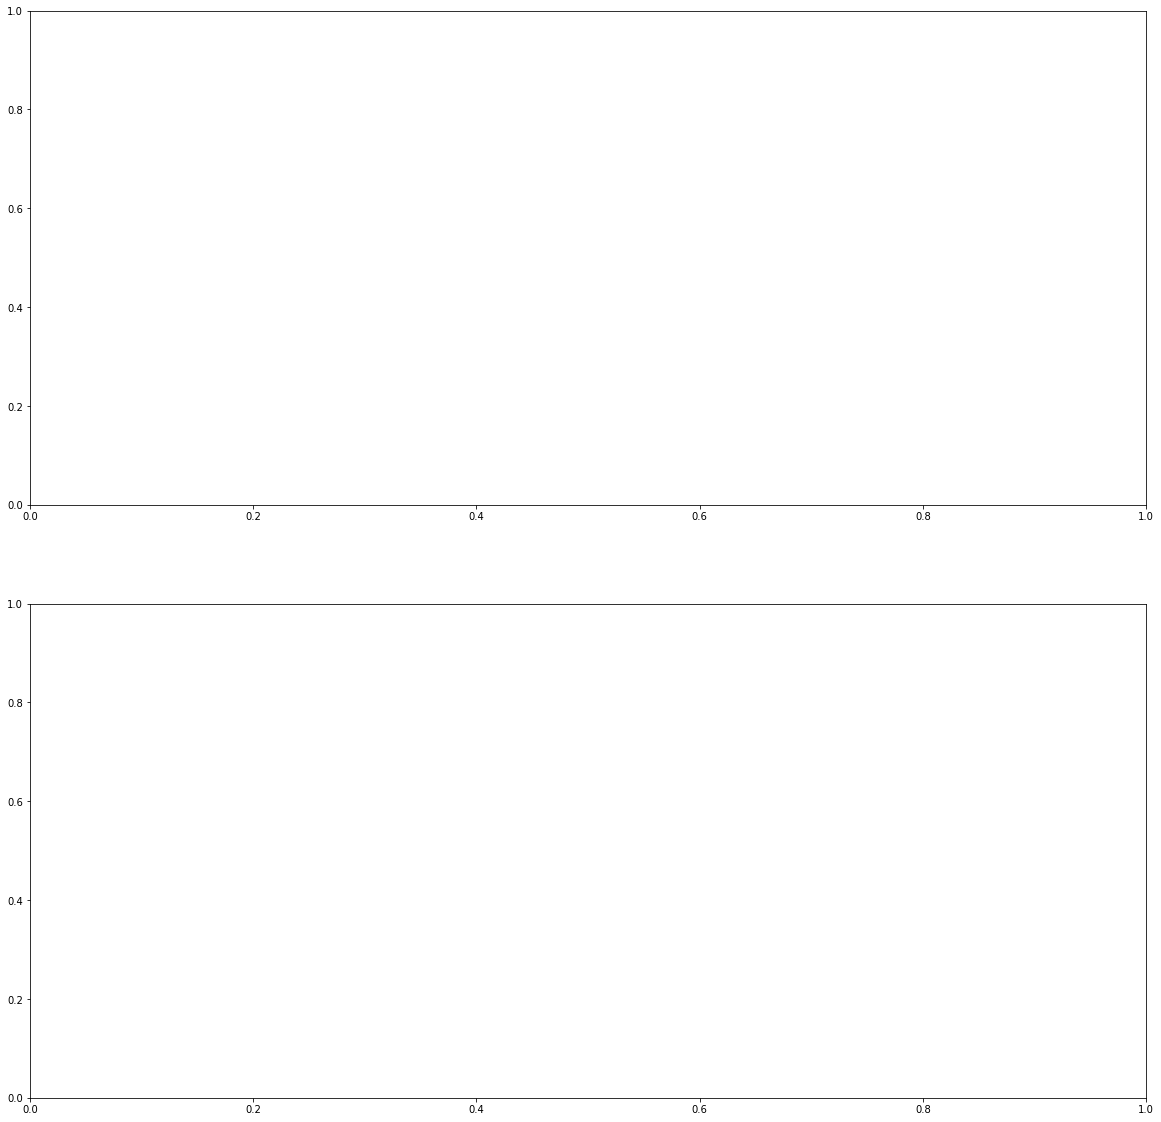

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "hocomoco_jolma_yang", transpose=True, n_replics=1000)
plt.show()

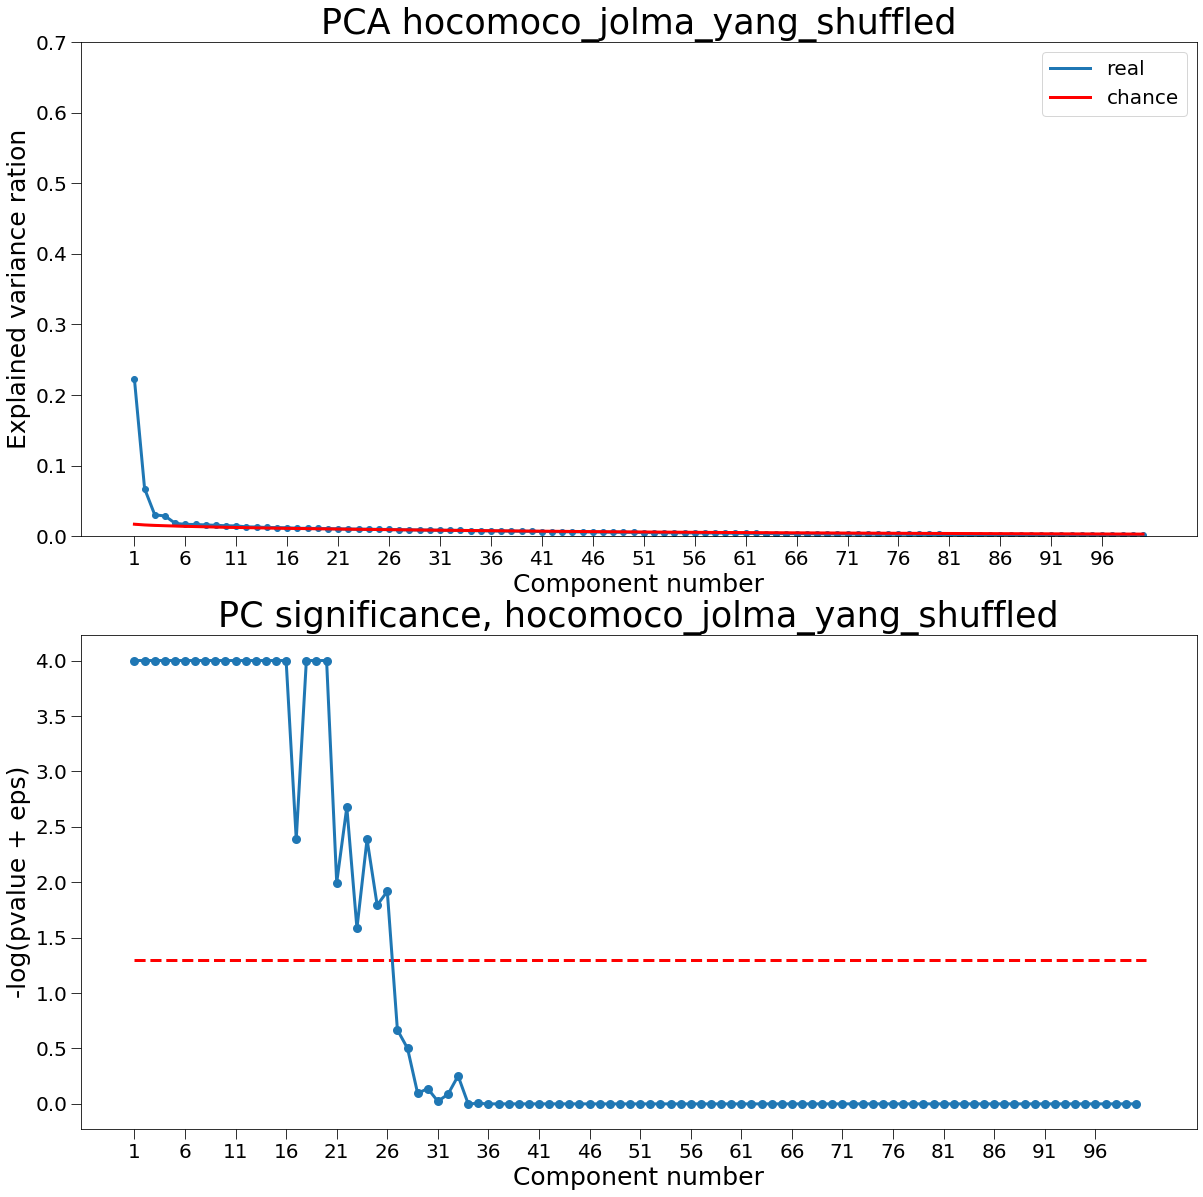

<Figure size 1440x1440 with 0 Axes>

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "hocomoco_jolma_yang_shuffled", transpose=True, n_replics=1000)
plt.show()

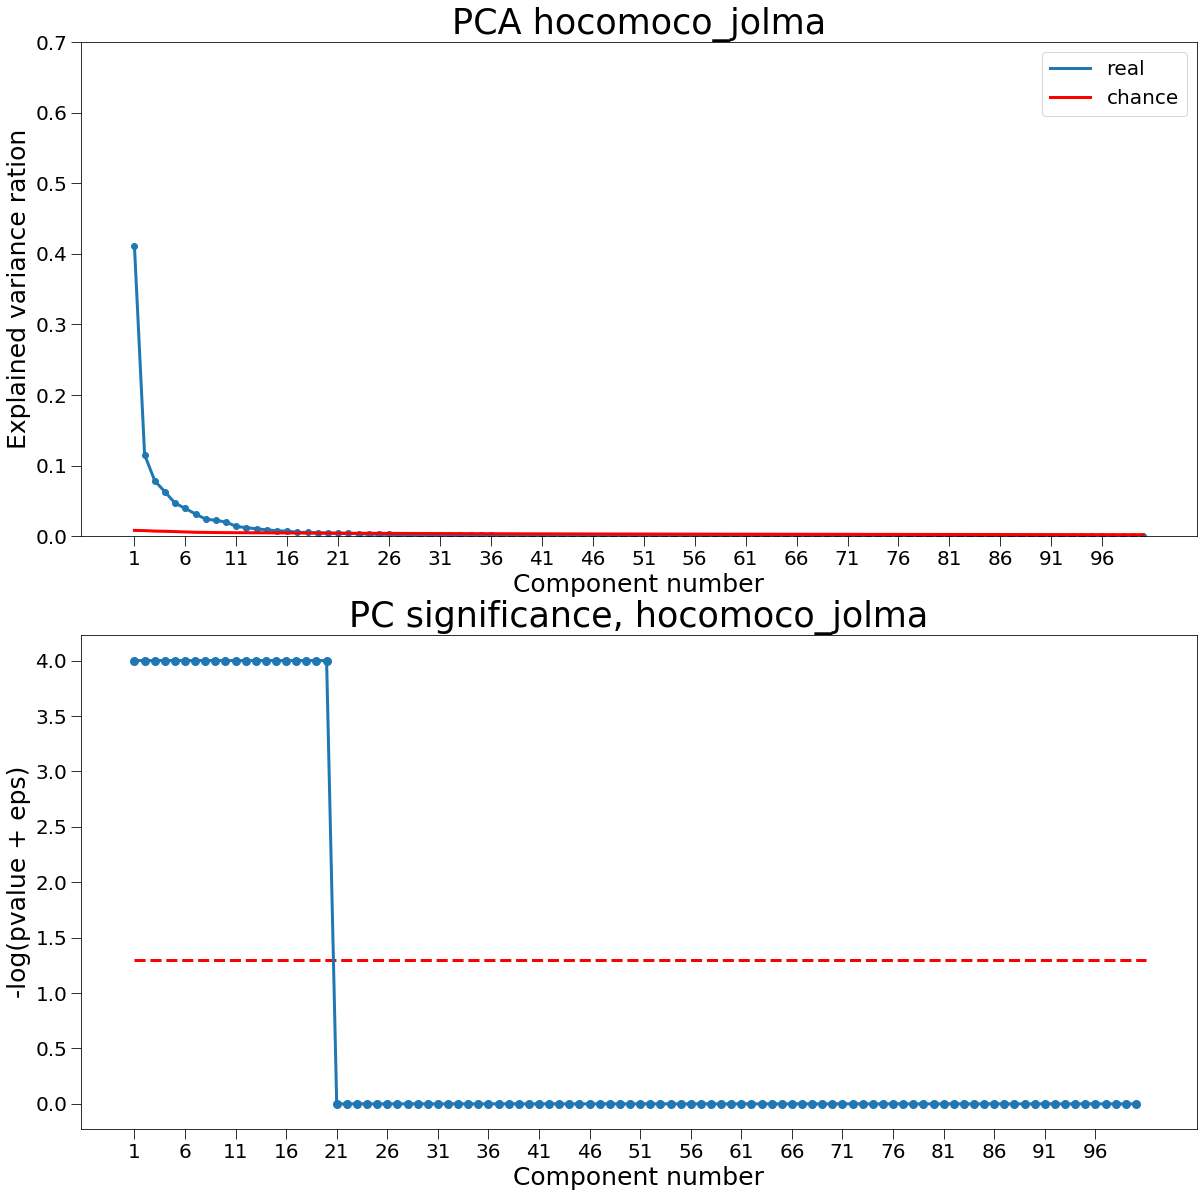

<Figure size 1440x1440 with 0 Axes>

In [39]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "hocomoco_jolma", transpose=True,n_replics=1000)
plt.show()

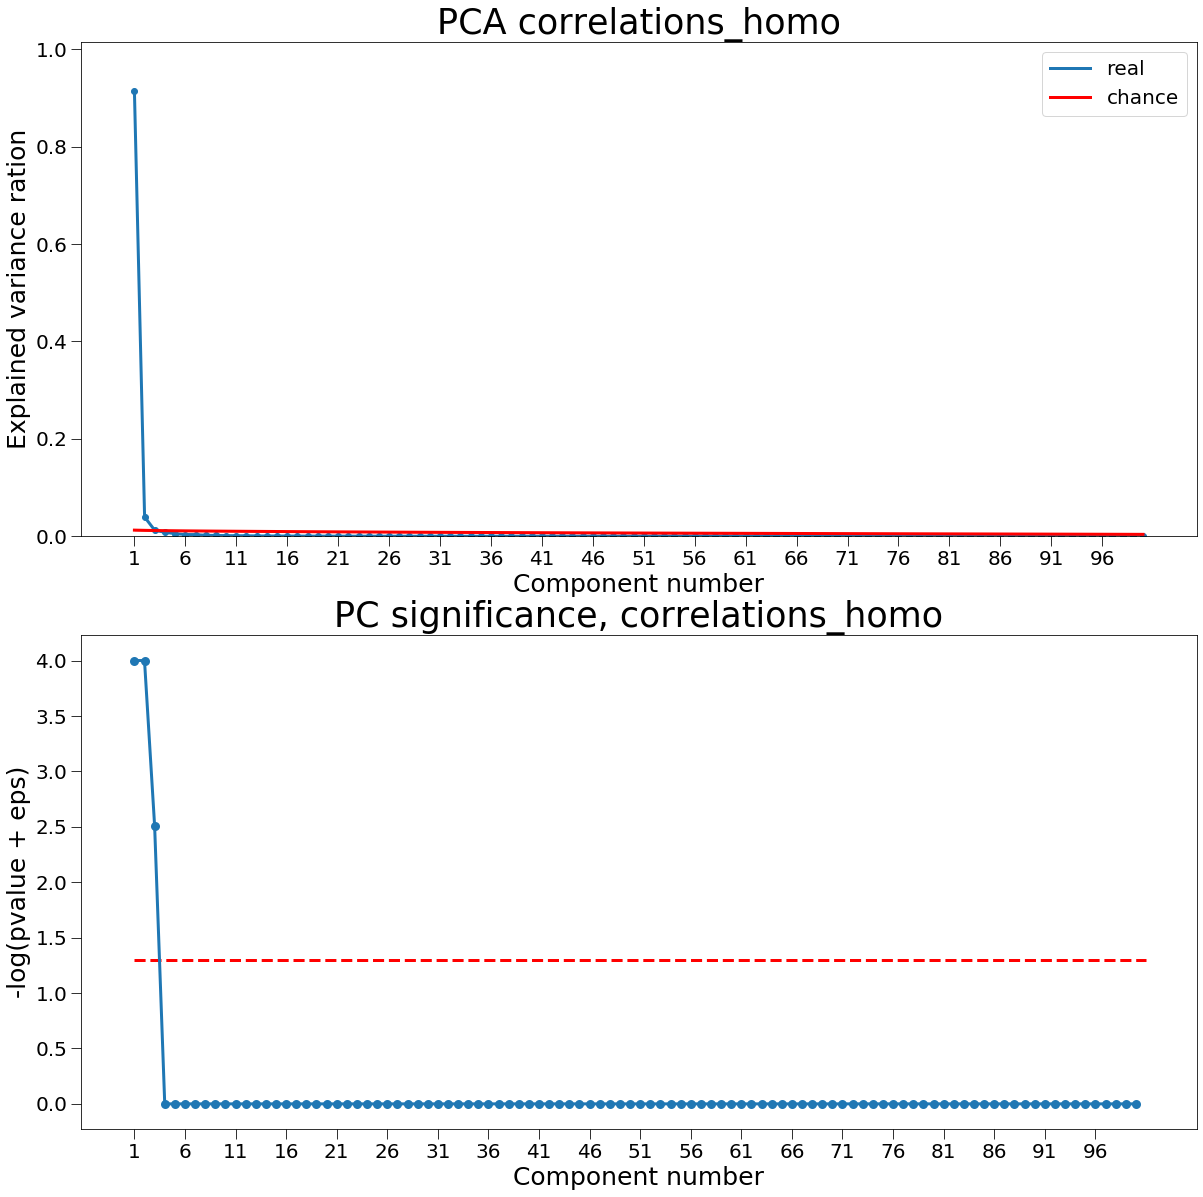

In [62]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "correlations_homo", transpose=False, n_replics=1000)
plt.show()

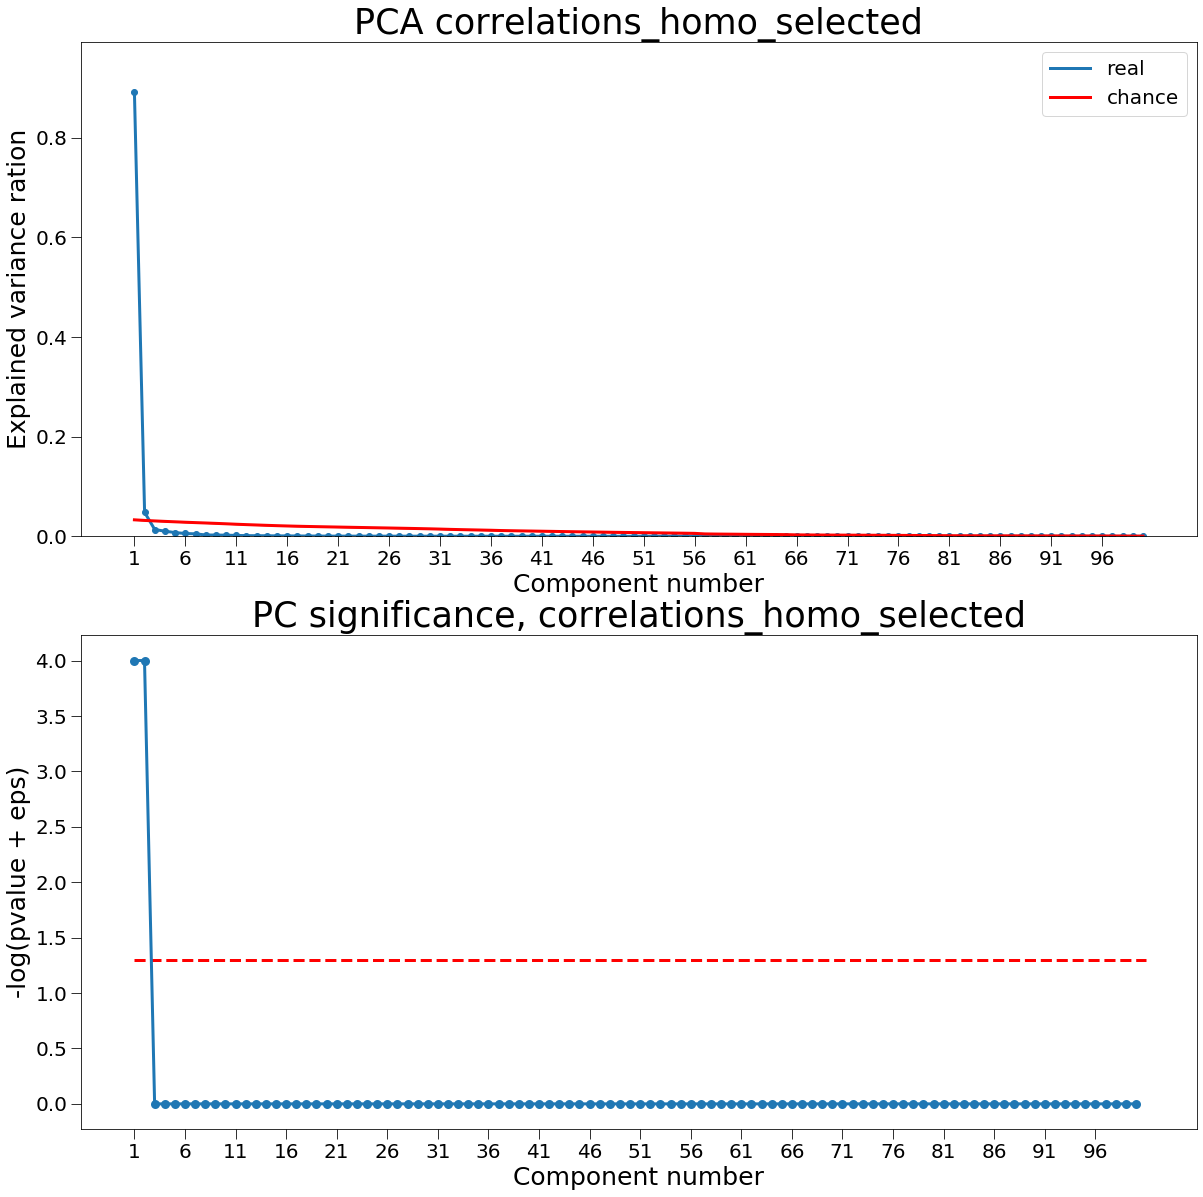

In [63]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "correlations_homo_selected", transpose=False, n_replics=1000)
plt.show()

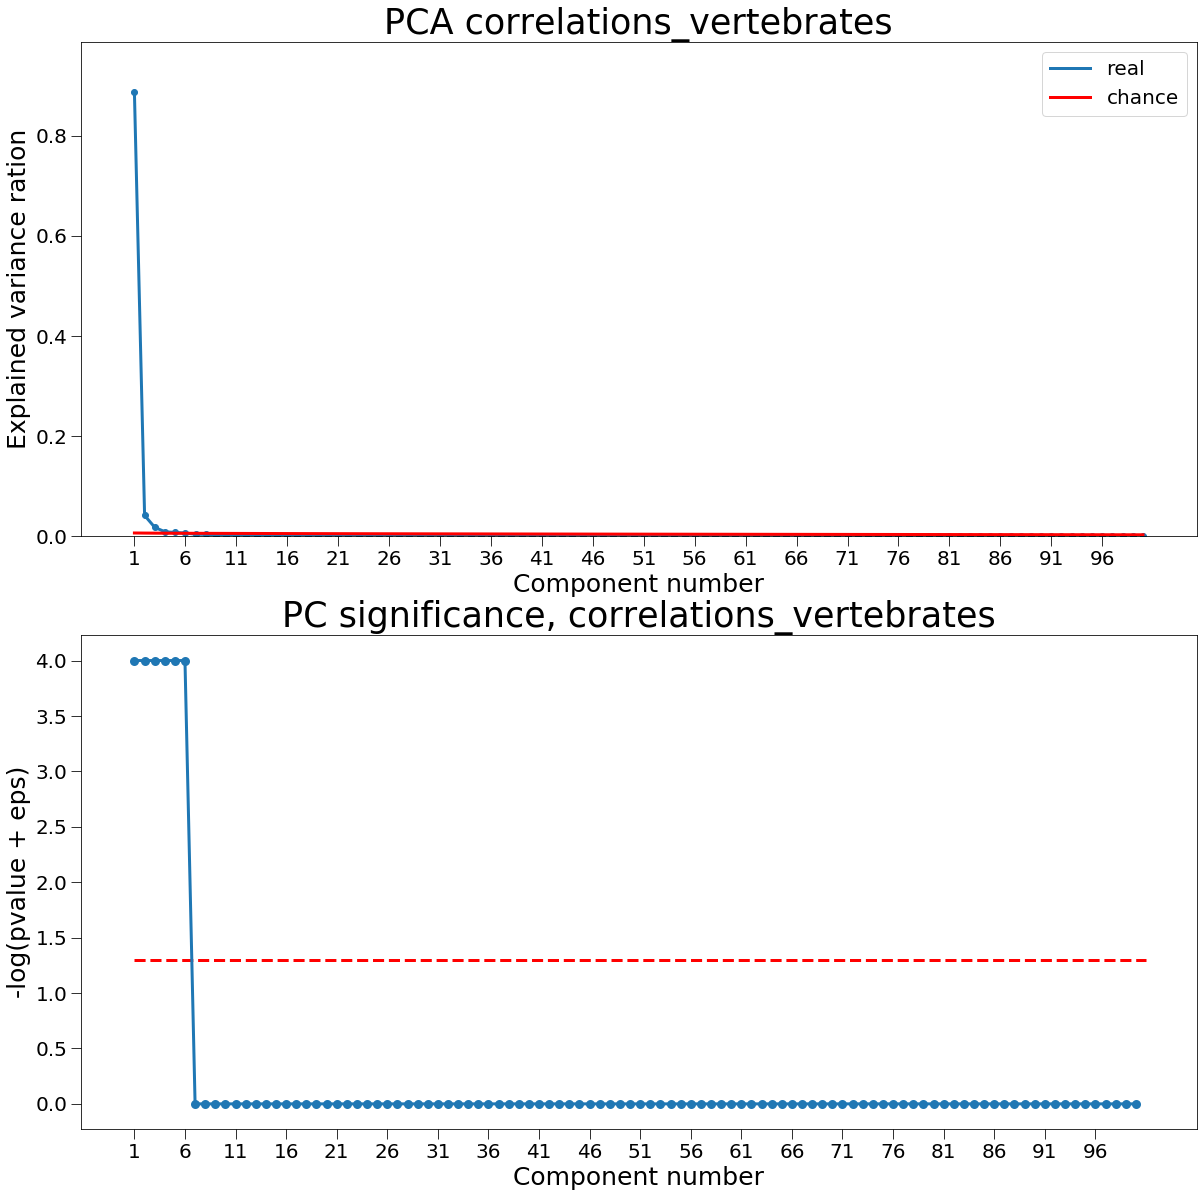

In [66]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "correlations_vertebrates", transpose=False, n_replics=1000)
plt.show()

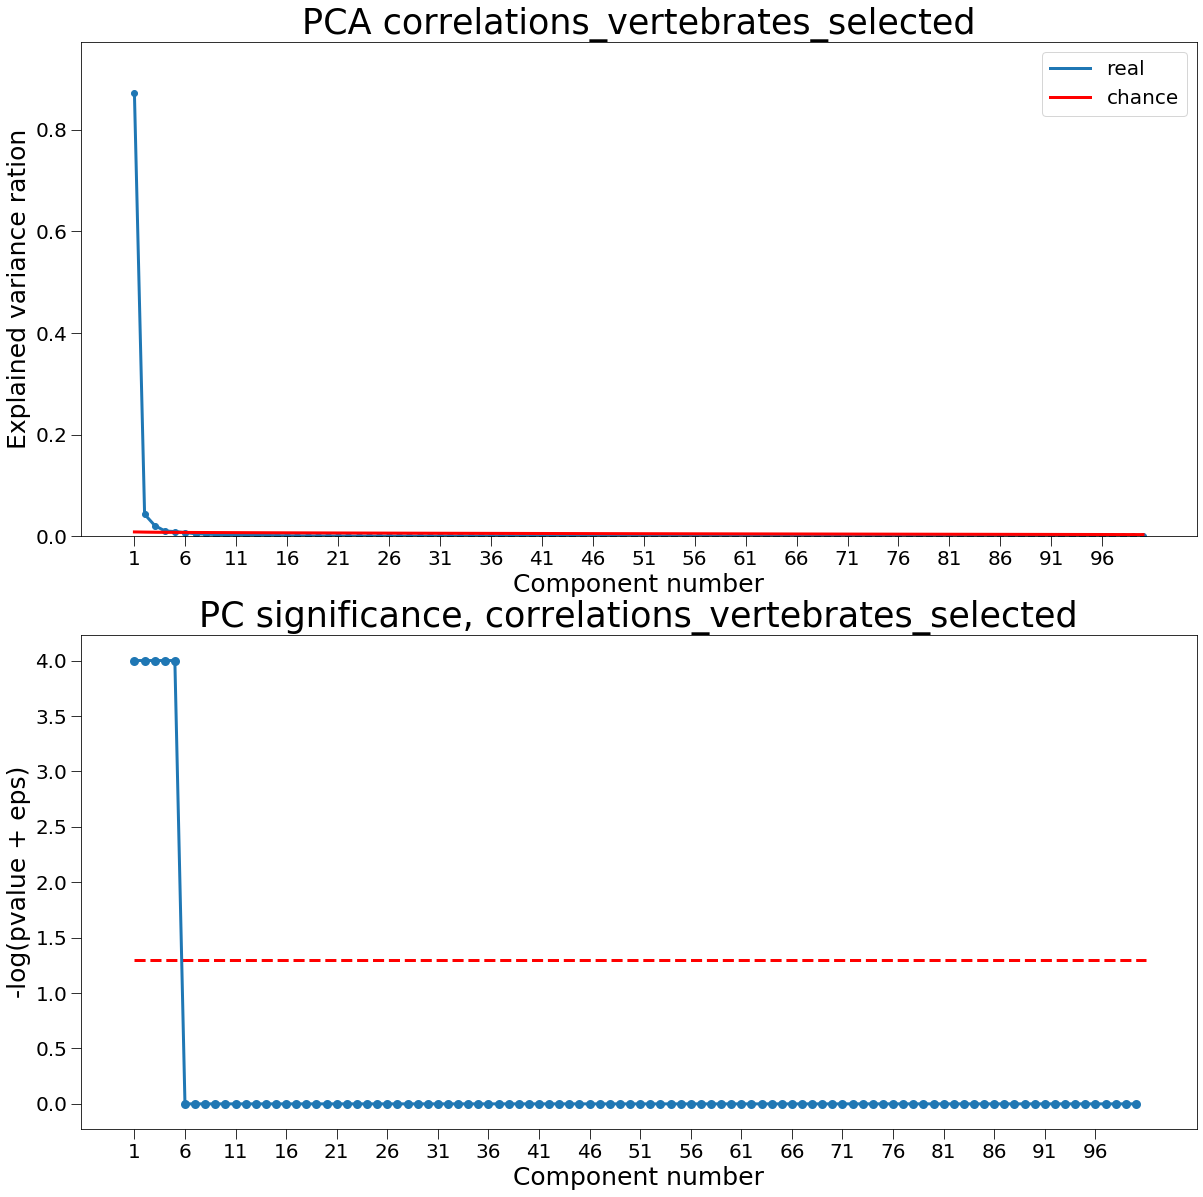

In [67]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "correlations_vertebrates_selected", transpose=False, n_replics=1000)
plt.show()

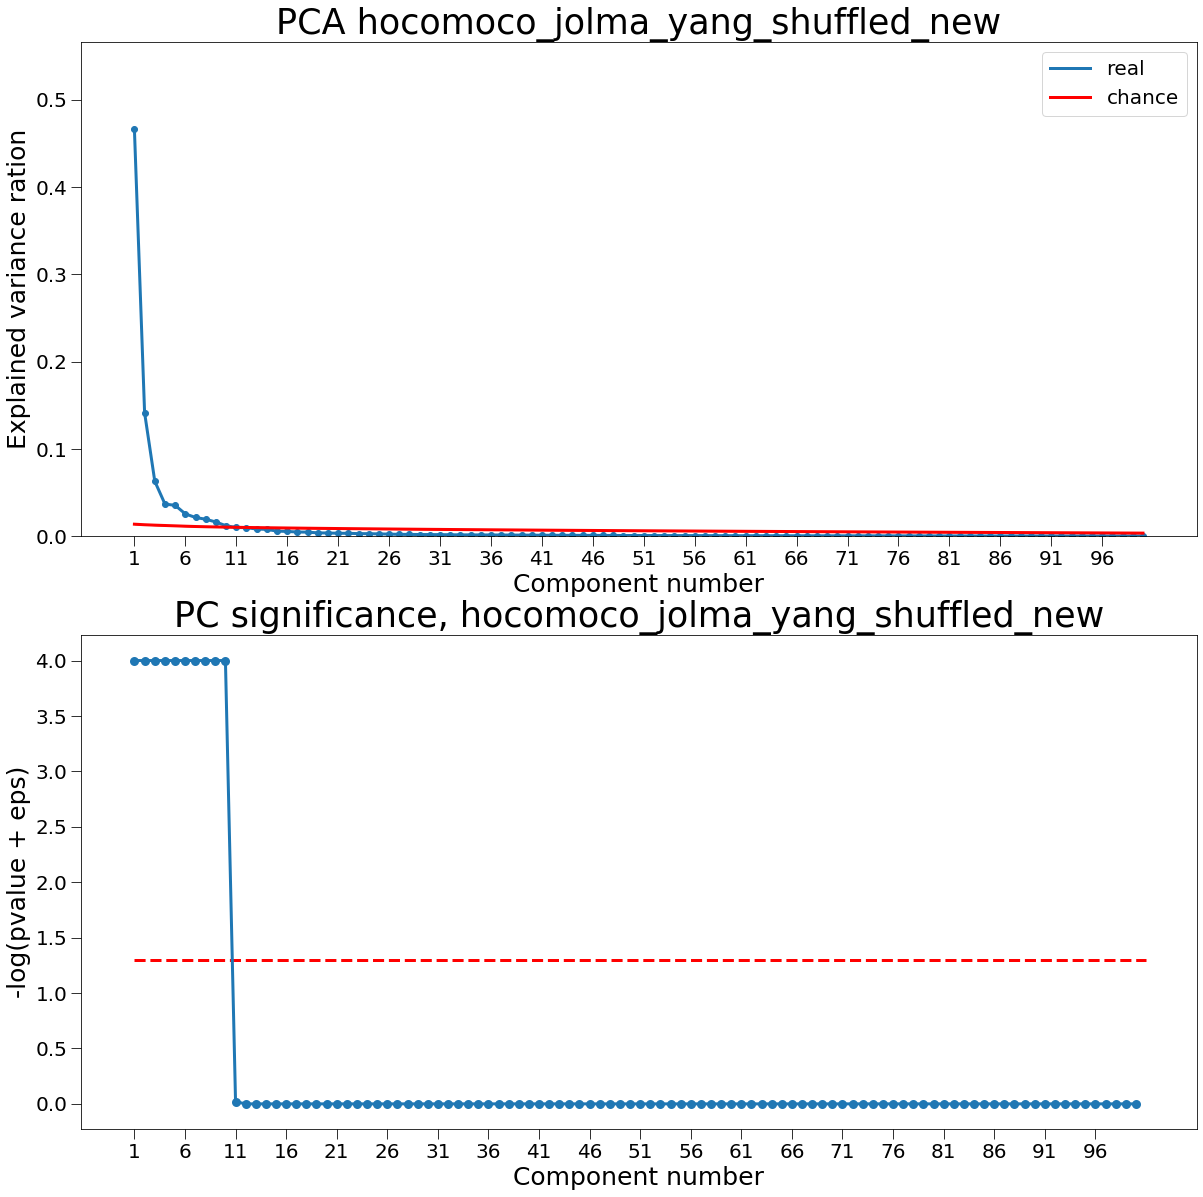

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "hocomoco_jolma_yang_shuffled_new", transpose=True, n_replics=1000)
plt.show()


0 iter
100 iter
200 iter
300 iter
400 iter
500 iter
600 iter
700 iter
800 iter
900 iter



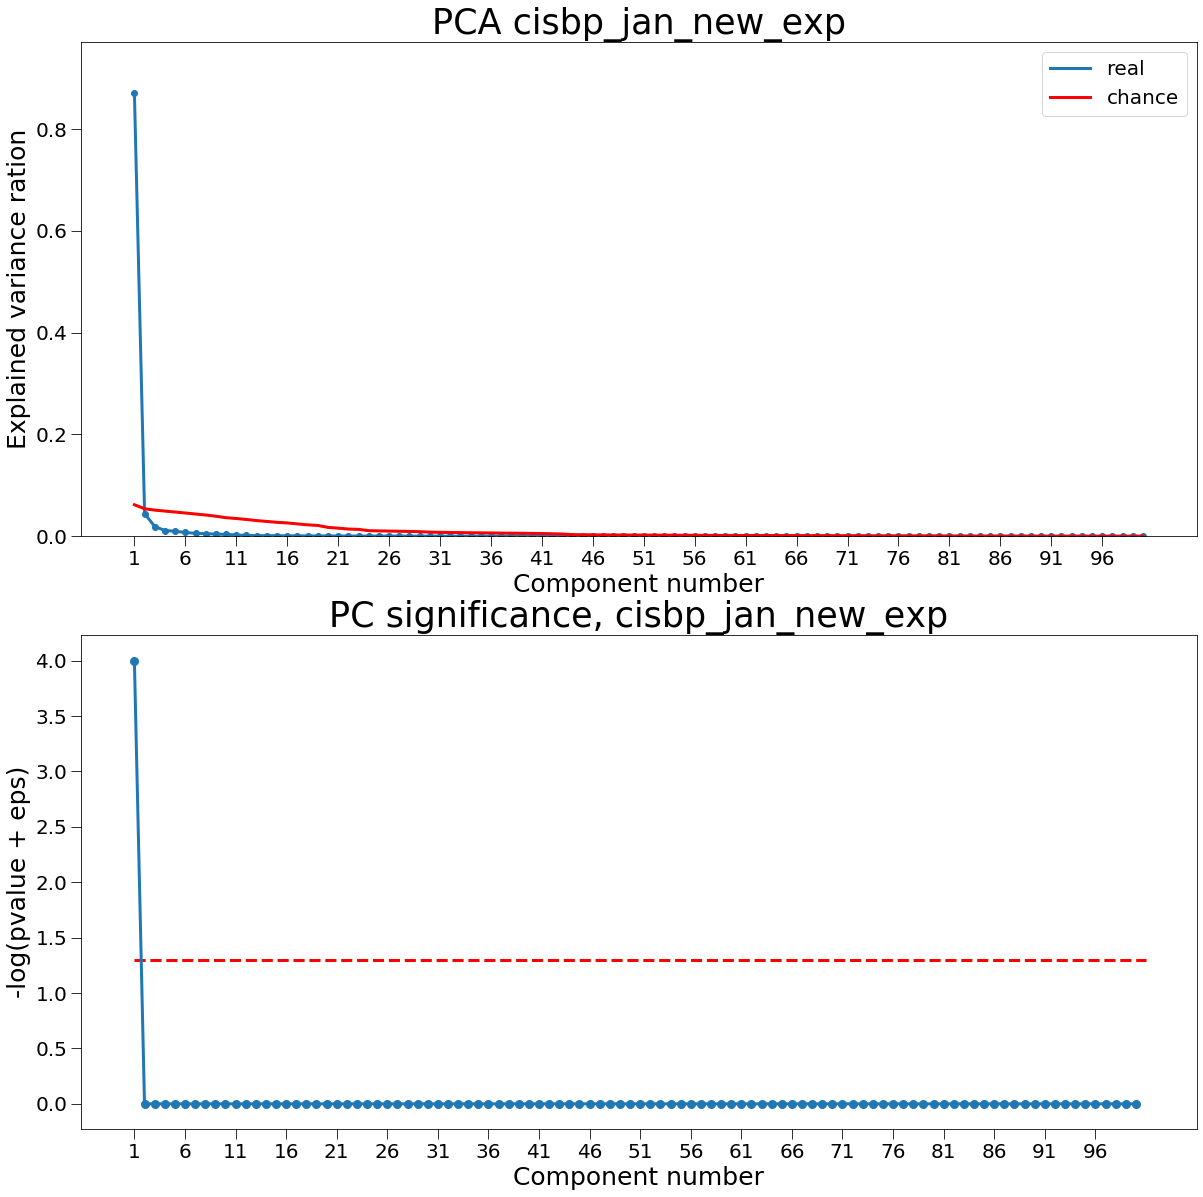

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "cisbp_jan_new_exp", transpose=False, n_replics=1000)
plt.show()

0 iter
100 iter
200 iter
300 iter
400 iter
500 iter
600 iter
700 iter
800 iter
900 iter



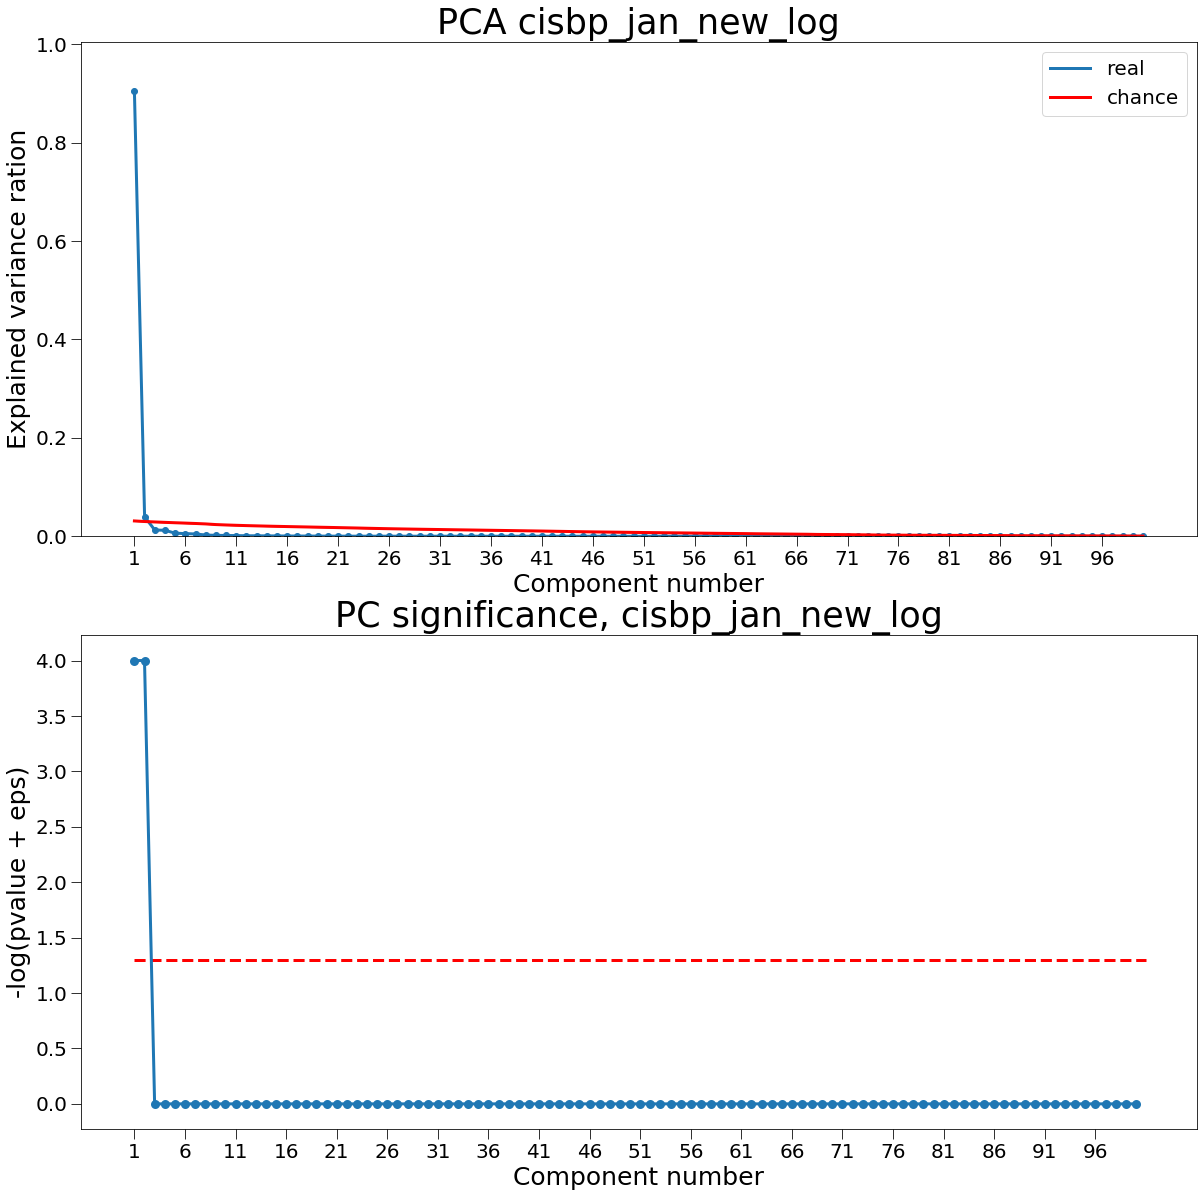

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.set_figheight(20)
f.set_figwidth(20)
pca_analysis(ax1, ax2, "cisbp_jan_new_log", transpose=False, n_replics=1000)
plt.show()